## Exploratory Data Analysis

In [1]:
import pandas as pd
ames = pd.read_csv('../ames.csv')

<AxesSubplot:>

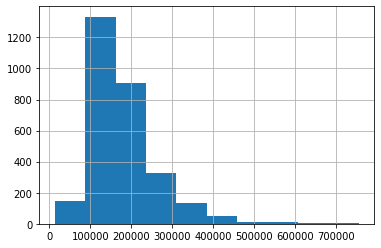

In [2]:
ames['Sale_Price'].hist()

In [3]:
import numpy as np
target = ames['Sale_Price']
features = ames.drop(columns='Sale_Price')
numeric_columns = ames.select_dtypes(include=np.number).columns.values
categorical_columns = ames.drop(columns=numeric_columns).columns.values
print( f"Numeric Columns: {len(numeric_columns)} \nCategorical Columns: {len(categorical_columns)}")

Numeric Columns: 35 
Categorical Columns: 46


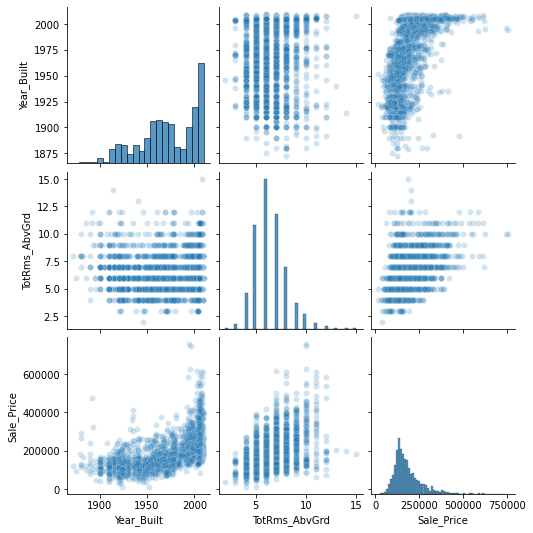

In [4]:
import seaborn as sns

sns.pairplot(
    data=ames[:5000]
    , vars = ['Year_Built','TotRms_AbvGrd','Sale_Price']
    , plot_kws={'alpha': 0.2});

## Modular Code & SciKit-Learn Model

In [5]:
from my_module import get_features_and_target
features, target = get_features_and_target('../ames.csv','Sale_Price')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    random_state=123,
    test_size=0.25
    )

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [8]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.6949157417705423

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8104251490010675

In [10]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.8744381936304358

## Feature Engineering

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lm_model_scaled = make_pipeline(StandardScaler(), LinearRegression())
lm_model_scaled.fit(X_train, y_train)
lm_model_scaled.score(X_test, y_test)

0.810500881595151

In [16]:
######## RUN THIS CODE CELL AS-IS ########

data = ames
features = data.drop(columns='Sale_Price')
target = data['Sale_Price']
# identify num_features and cat_features
num_features = features.select_dtypes(np.number)
cat_features = features.select_dtypes(object)
# get columns of interest
numerical_columns = num_features.columns
ordinal_columns = cat_features.filter(regex='Qual').columns
categorical_columns = cat_features.drop(columns=ordinal_columns).columns

# replace unique values in our ordinal columns (i.e. "No_basement", "No_garage") with 'NA'
for col in ordinal_columns:
    features[col] = features[col].replace(to_replace='No_.*', value='NA', regex=True)
    
# split full feature set (numeric, categorical, & ordinal features) into train & test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=123)

In [17]:
######## RUN THIS CODE CELL AS-IS ########

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# create our numeric, categorical, and ordinal preprocessor encoders
numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

ordinal_categories = [
    "NA", "Very_Poor", "Poor", "Fair", "Below_Average", "Average", "Typical",
    "Above_Average", "Good", "Very_Good", "Excellent", "Very_Excellent"
]
list_of_ord_cats = [ordinal_categories for col in ordinal_columns]
ordinal_preprocessor = OrdinalEncoder(categories=list_of_ord_cats)

In [18]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('standard_scaler', numerical_preprocessor, numerical_columns),
    ('one_hot_encoder', categorical_preprocessor, categorical_columns),
    ('ordinal_encoder', ordinal_preprocessor, ordinal_columns),
])

In [19]:
lm_full = make_pipeline(preprocessor, LinearRegression())
_ = lm_full.fit(X_train, y_train)
lm_full.score(X_test, y_test)

0.8849930088746839

## Part 2

In [20]:
######## RUN THIS CODE CELL AS-IS ########

from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [21]:
######## RUN THIS CODE CELL AS-IS ########

from sklearn.pipeline import Pipeline

# create preprocessor & modeling pipeline
rf = RandomForestRegressor(random_state=123)
pipeline = Pipeline([('prep', preprocessor), ('rf', rf)])

# specify hyperparameter distributions to randomly sample from
param_distributions = {
    'rf__n_estimators': loguniform_int(50, 1000),
    'rf__max_features': loguniform(.1, .8),
    'rf__max_depth': loguniform_int(2, 30),
    'rf__min_samples_leaf': loguniform_int(1, 100),
    'rf__max_samples': loguniform(.5, 1),
}

In [31]:
%%time
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=25,
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
)

results = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 1min 9s


In [32]:
results.best_score_

-25772.8597934614

In [33]:
results.best_params_

{'rf__max_depth': 11,
 'rf__max_features': 0.5361398557733895,
 'rf__max_samples': 0.8847849216883664,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 157}